In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
#load and merge speeches, speakermap and decr files

def loadCongress(path, congress):
    n = congress

    speeches = pd.read_csv(f"{path}/speeches_{n}.txt", sep="|", quoting=3, on_bad_lines='skip', encoding='latin-1')
    descr = pd.read_csv(f"{path}/descr_{n}.txt", sep="|", quoting=3, on_bad_lines='skip', encoding='latin-1')
    speakermap = pd.read_csv(f"{path}/{n}_SpeakerMap.txt", sep="|", quoting=3, on_bad_lines='skip', encoding='latin-1')

    df = speeches.merge(descr, on='speech_id', how='left')
    df = df.merge(speakermap, on='speech_id', how='left')
    
    keepCols = ["speech_id", "speech", "date", "chamber_x", "word_count", "party", "state_x", "speaker"]
    df = df[keepCols]
    df = df.rename(columns={"chamber_x": "chamber", "state_x": "state"})
    df["congress"] = congress

    return df

In [ ]:
path = "../data/hein-daily"
df109 = loadCongress(path, 109)

print(df109.info())
print(df109.head(3))

In [ ]:
#checking how many null party speeches are there
print(df109[df109["party"].isna()]["speech"].str.split().str.len().describe())

In [ ]:
#checking if i should drop speeches with less than 150 words
print(f"Before: {len(df109)}")
print(f"After 150w filter: {len(df109[df109['word_count'] >= 150])}")
print(f"Dropped: {len(df109[df109['word_count'] < 150])}")

In [ ]:
# longest dropped speech - did we lose anything good?
dropped = df109[df109['word_count'] < 150]
print(dropped.nlargest(3, 'word_count')[['speech', 'word_count', 'party', 'speaker']])

# shortest kept speech - are we keeping noise?
kept = df109[df109['word_count'] >= 150]
print(kept.nsmallest(3, 'word_count')[['speech', 'word_count', 'party', 'speaker']])

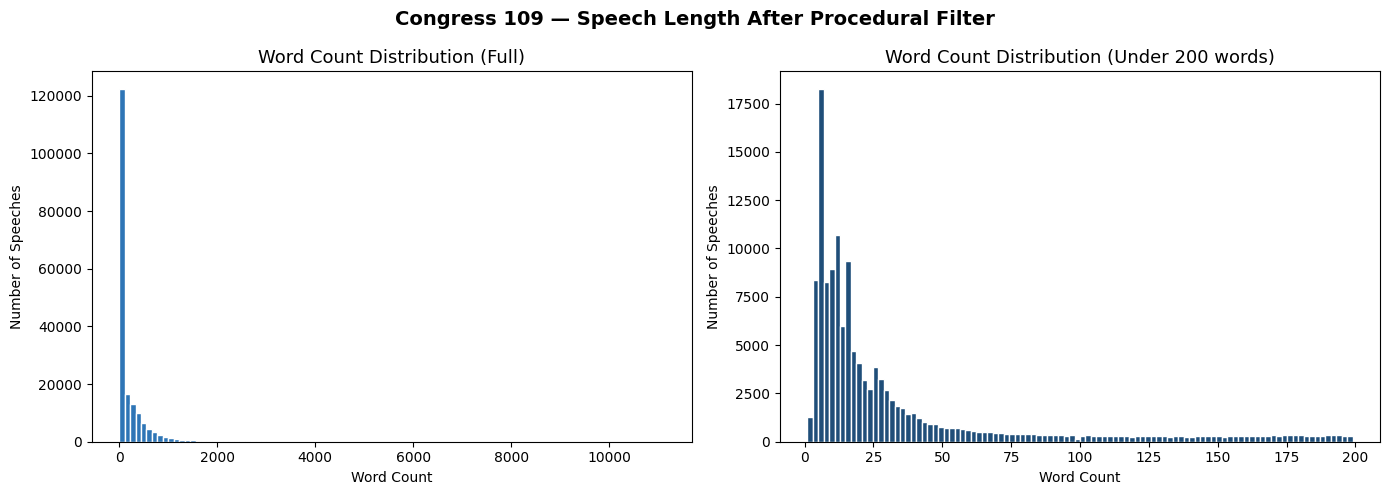

In [32]:
#deciding word cut off 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# full distribution
axes[0].hist(df109["word_count"], bins=100, color="#2E75B6", edgecolor="white")
axes[0].set_title("Word Count Distribution (Full)", fontsize=13)
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Number of Speeches")

# zoomed in under 500 words to see the low end clearly
axes[1].hist(df109[df109["word_count"] < 200]["word_count"], bins=100, color="#1F4E79", edgecolor="white")
axes[1].set_title("Word Count Distribution (Under 200 words)", fontsize=13)
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Number of Speeches")

plt.suptitle("Congress 109 — Speech Length After Procedural Filter", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../plots/wordcount_dist_109_all.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
##--------------------------clean obvious noise--------------------------------------##

#remove the speeches of procedural speakers
def removeProcedural(df):
    
    proceduralSpeakers = [
        "the speaker", "the clerk", "the chair",
        "the presiding officer", "the chief justice",
        "the acting chair", "the acting president pro tempore",
        "the secretary"
    ]
    
    df["speakerClean"] = df["speaker"].str.lower().str.strip()
    dfClean = df[~df["speakerClean"].str.contains('|'.join(proceduralSpeakers), na=False)]
    dfClean = dfClean.drop(columns=["speakerClean"])
    
    removed = len(df) - len(dfClean)
    
    print('Remove procedural speakers')
    print(f"Before: {len(df)} speeches")
    print(f"After:  {len(dfClean)} speeches")
    print(f"Removed: {removed} procedural speeches ({removed/len(df)*100:.1f}%)")
    print('-------------------------')
    
    return dfClean

#remove speeches with less than 50 words
def filterWordCount(df, minWords=50):
    dfClean = df[df["word_count"] >= minWords]
    
    removed = len(df) - len(dfClean)

    print('Filter words')
    print(f"Before: {len(df)} speeches")
    print(f"After:  {len(dfClean)} speeches")
    print(f"Removed: {removed} short speeches ({removed/len(df)*100:.1f}%)")
    print('-------------------------')
    
    return dfClean

In [41]:
##-----------------------------parse date----------------------------##

def parseDate(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    return df

In [42]:
def cleanCongress(df, applyRemoveProcedural=True, minWords=50):
    
    if applyRemoveProcedural:
        df = removeProcedural(df)
    
    df = filterWordCount(df, minWords)
    df = parseDate(df)
    
    return df

In [43]:
df109clean = cleanCongress(df109)

print(df109clean["date"].dtype)
print(df109clean["date"].head())

Remove procedural speakers
Before: 187643 speeches
After:  136151 speeches
Removed: 51492 procedural speeches (27.4%)
-------------------------
Filter words
Before: 136151 speeches
After:  76577 speeches
Removed: 59574 short speeches (43.8%)
-------------------------
datetime64[ns]
1    2005-01-04
3    2005-01-04
30   2005-01-04
32   2005-01-04
34   2005-01-04
Name: date, dtype: datetime64[ns]


In [44]:
##---------------aggregate speeches by each week-----------------##

def aggregateWeekly(df):
    df["week"] = df["date"].dt.to_period("W")
    
    weekly = df.groupby("week").agg(
        speech=("speech", " ".join),
        speechCount=("speech_id", "count"),
        congress=("congress", "first")
    ).reset_index()
    
    print(f"Total weeks: {len(weekly)}")
    print(weekly.head())
    
    return weekly

In [45]:
df109weekly = aggregateWeekly(df109clean)

Total weeks: 70
                    week                                             speech  \
0  2005-01-03/2005-01-09  Mr. President. these last 9 days have brought ...   
1  2005-01-17/2005-01-23  Mr. Speaker. the Committee on Rules may meet n...   
2  2005-01-24/2005-01-30  Mr. President. this afternoon. we will be in a...   
3  2005-01-31/2005-02-06  Mr. President. today we are in a period for mo...   
4  2005-02-07/2005-02-13  Mr. President. today we have a period of morni...   

   speechCount  congress  
0          503       109  
1           73       109  
2          722       109  
3          665       109  
4          960       109  
